In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [22]:
# files to read => chb01_03.edf, chb01_04.edf, chb01_15.edf,  chb01_16.edf,  chb01_18.edf,  chb01_21.edf,  chb01_26.edf,  chb02_16.edf, chb02_19.edf, chb03_01.edf, chb03_02.edf, chb03_03.edf, chb03_04.edf
files_to_read = ['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb02_19.edf', 'chb03_01.edf', 'chb03_02.edf', 'chb03_03.edf', 'chb03_04.edf', 'chb04_05.edf']
seizure_seconds_each_file_start_and_end_seconds = [('chb01_03.edf',2996, 3036), ('chb01_04.edf', 1467, 1494), ('chb01_15.edf', 1732, 1772), ('chb01_16.edf',1015, 1066),
 ('chb01_18.edf', 1720, 1810), ('chb01_21.edf', 327, 420), ('chb01_26.edf', 1862, 1963), ('chb02_16.edf', 130, 212), ('chb02_19.edf', 2972, 3053),
  ('chb03_01.edf', 362, 414), ('chb03_02.edf', 731, 796), ('chb03_03.edf', 432, 501), ('chb03_04.edf', 2162, 2214), ('chb04_05.edf', 7804, 7853)]
signals = []
for file in files_to_read:
        f = pyedflib.EdfReader(file)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        sigbufs = np.zeros((2, f.getNSamples()[0]))
        sigbufs[0] = f.readSignal(fz_cz_index)
        sigbufs[1] = f.readSignal(cz_pz_index)
        signals.append(np.array(sigbufs))
        f.close()
len(signals)

14

In [23]:
signals[0].shape

(2, 921600)

In [60]:
#split each signal into 20 * 256 second windows
window_size = 20 * 256
windowed_signals = np.zeros((0, 2, window_size))
y_labels = []
index = 0
for signal in signals:
    print(index)
    try:
        start_time = seizure_seconds_each_file_start_and_end_seconds[index][1]*256
        end_time = seizure_seconds_each_file_start_and_end_seconds[index][2]*256
        for i in range(0, signal.shape[1], window_size):
            windowed_signals = np.append(windowed_signals, np.array([signal[:, i:i+window_size]]), axis=0)
            #if i and i+window_size contains seizure time, then label it as 1, otherwise 0
            if i in range(start_time, end_time) or i+window_size in range(start_time, end_time):
                y_labels.append(1)
            else:
                y_labels.append(0)
        index += 1
    except:
        index += 1
        continue
    

In [61]:
print(len(windowed_signals), len(y_labels))

2619 2619


In [62]:
sum(y_labels)

57

In [66]:
windowed_signals.shape

(2619, 2, 5120)

 ...]

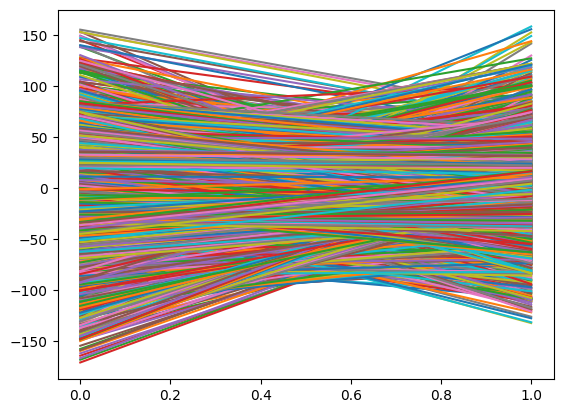

In [64]:
plt.plot(windowed_signals[0])

In [67]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(windowed_signals, y_labels, random_state=42)

In [68]:
X_train.shape

(1964, 2, 5120)

In [69]:
#one hot encode target column
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [96]:
#now lets make the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=10, activation='relu', input_shape=(5120, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.save("model.h5")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 5111, 256)         5376      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2555, 256)        0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 2555, 256)         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 2546, 128)         327808    
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 1273, 128)        0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1273, 128)       

In [97]:
X_train.shape

(1964, 5120, 2)

In [98]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(1964, 5120, 2)

In [100]:
model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)


Epoch 1/10
62/62 - 165s - loss: 0.2156 - accuracy: 0.9766 - 165s/epoch - 3s/step
Epoch 2/10
62/62 - 185s - loss: 0.1560 - accuracy: 0.9766 - 185s/epoch - 3s/step
Epoch 3/10
62/62 - 180s - loss: 0.1117 - accuracy: 0.9766 - 180s/epoch - 3s/step
Epoch 4/10
62/62 - 177s - loss: 0.0884 - accuracy: 0.9766 - 177s/epoch - 3s/step
Epoch 5/10
62/62 - 181s - loss: 0.0697 - accuracy: 0.9766 - 181s/epoch - 3s/step
Epoch 6/10
62/62 - 175s - loss: 0.0454 - accuracy: 0.9771 - 175s/epoch - 3s/step
Epoch 7/10
62/62 - 184s - loss: 0.0456 - accuracy: 0.9857 - 184s/epoch - 3s/step
Epoch 8/10
62/62 - 179s - loss: 0.0939 - accuracy: 0.9786 - 179s/epoch - 3s/step
Epoch 9/10
62/62 - 176s - loss: 0.0815 - accuracy: 0.9781 - 176s/epoch - 3s/step
Epoch 10/10
62/62 - 176s - loss: 0.0392 - accuracy: 0.9903 - 176s/epoch - 3s/step


In [89]:
#evaluate the model
model_loss, model_accuracy = model.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

21/21 - 10s - loss: 16.4482 - accuracy: 0.9832 - 10s/epoch - 477ms/step
Normal Neural Network - Loss: 16.448238372802734, Accuracy: 0.9832060933113098


In [ ]:
model.save("model1.h5")

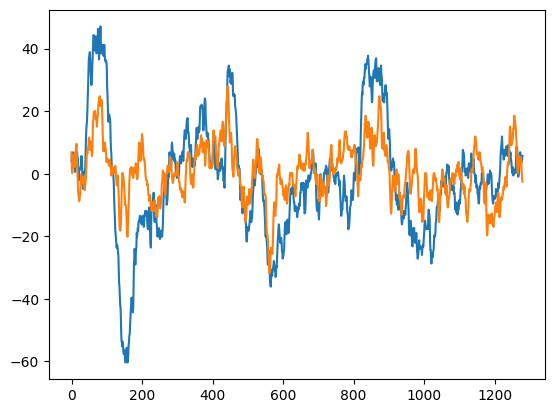

In [328]:
plt.plot(X_test[1][0])